# Importing Libraries

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Image Gradient Method to Find Edges

In [19]:
def compute_gradients(img, epsilon = 1):

    img = img.astype(np.float32)
    
    gradient_x = np.zeros_like(img)
    gradient_x[:, 1:] = (img[:, 1:] - img[:, :-1])/ (2*epsilon)
    
    gradient_y = np.zeros_like(img)
    gradient_y[1:, :] = (img[1:, :] - img[:-1, :]) / (2*epsilon)
    
    return gradient_x, gradient_y

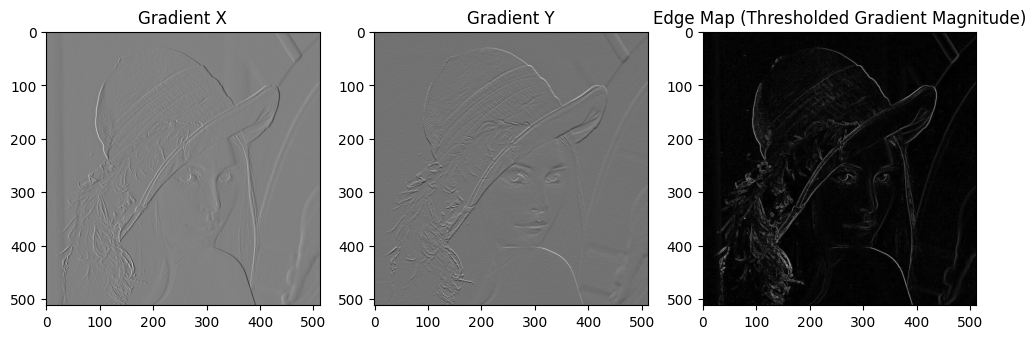

In [20]:
image = cv2.imread('Images/lena.png', cv2.IMREAD_GRAYSCALE)

gradient_x, gradient_y = compute_gradients(image)

gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX)
_, edge_map = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(gradient_x, cmap='gray')
plt.title('Gradient X')

plt.subplot(1, 3, 2)
plt.imshow(gradient_y, cmap='gray')
plt.title('Gradient Y')

plt.subplot(1, 3, 3)
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Edge Map (Thresholded Gradient Magnitude)')

plt.show()

# 2. Canny Edge Detection Algorithm for Finding Edges

## Gaussian Filter

In [32]:
def gaussian_filter(image, kernel_size=5, sigma=1.4):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

## Gradient Calculation

In [33]:
def sobel_filters(image):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    Ix = cv2.filter2D(image, -1, Kx)  
    Iy = cv2.filter2D(image, -1, Ky) 
    
    G = np.hypot(Ix, Iy) 
    G = G / G.max() * 255 
    
    theta = np.arctan2(Iy, Ix)  
    
    return G, theta

## Non Maximum Suppression

In [34]:
def non_maximum_suppression(G, theta):
    M, N = G.shape
    Z = np.zeros((M, N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M - 1):
        for j in range(1, N - 1):
            try:
                q = 255
                r = 255
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = G[i, j + 1]
                    r = G[i, j - 1]
                elif 22.5 <= angle[i, j] < 67.5:
                    q = G[i + 1, j - 1]
                    r = G[i - 1, j + 1]
                elif 67.5 <= angle[i, j] < 112.5:
                    q = G[i + 1, j]
                    r = G[i - 1, j]
                elif 112.5 <= angle[i, j] < 157.5:
                    q = G[i - 1, j - 1]
                    r = G[i + 1, j + 1]

                if (G[i, j] >= q) and (G[i, j] >= r):
                    Z[i, j] = G[i, j]
                else:
                    Z[i, j] = 0

            except IndexError as e:
                pass

    return Z

## Double Thresholding

In [35]:
def double_threshold(image, low_threshold_ratio=0.05, high_threshold_ratio=0.15):
    high_threshold = image.max() * high_threshold_ratio
    low_threshold = high_threshold * low_threshold_ratio

    M, N = image.shape
    res = np.zeros((M, N), dtype=np.int32)

    strong_i, strong_j = np.where(image >= high_threshold)
    weak_i, weak_j = np.where((image <= high_threshold) & (image >= low_threshold))

    res[strong_i, strong_j] = 255
    res[weak_i, weak_j] = 75

    return res

## Edge Tracking by Hysteresis

In [36]:
def edge_tracking_by_hysteresis(image):
    M, N = image.shape
    for i in range(1, M - 1):
        for j in range(1, N - 1):
            if (image[i, j] == 75):
                if ((image[i + 1, j - 1] == 255) or (image[i + 1, j] == 255) or (image[i + 1, j + 1] == 255)
                        or (image[i, j - 1] == 255) or (image[i, j + 1] == 255)
                        or (image[i - 1, j - 1] == 255) or (image[i - 1, j] == 255) or (image[i - 1, j + 1] == 255)):
                    image[i, j] = 255
                else:
                    image[i, j] = 0
    return image

## Canny Edge Detection Function

In [ ]:
def canny_edge_detection(image, low_threshold_ratio=0.05, high_threshold_ratio=0.15):
    
    smoothed_image = gaussian_filter(image)
    G, theta = sobel_filters(smoothed_image)
    non_max_img = non_maximum_suppression(G, theta)
    threshold_img = double_threshold(non_max_img, low_threshold_ratio, high_threshold_ratio)
    edge_image = edge_tracking_by_hysteresis(threshold_img)

    return edge_image

## Application

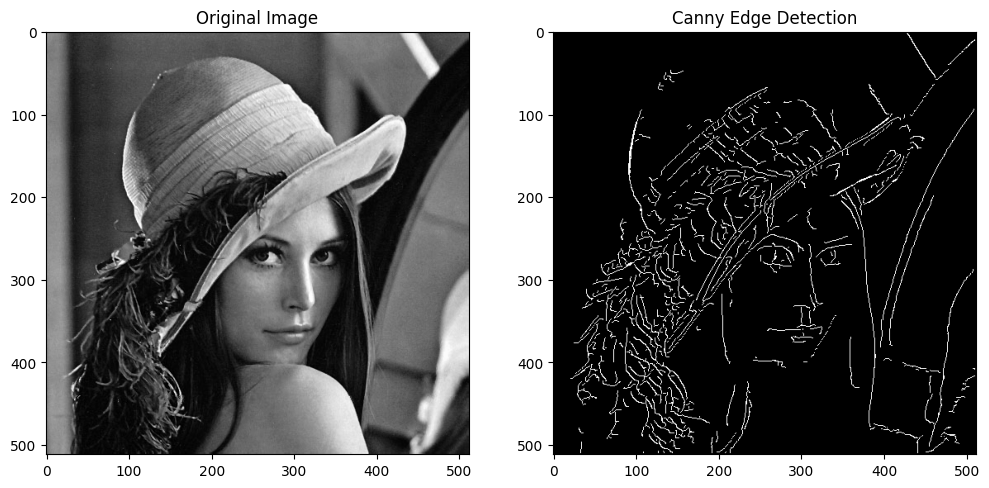

In [37]:
image = cv2.imread('Images/lena.png', cv2.IMREAD_GRAYSCALE)

canny_edges = canny_edge_detection(image)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(canny_edges, cmap='gray')
plt.title('Canny Edge Detection')

plt.show()

# 3. Sobel, Prewitt, and Robinson Compass Mask for Finding Edges

## Sobel Kernels

In [21]:
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

sobel_y = np.array([[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]])

## Prewitt Kernels

In [22]:
prewitt_x = np.array([[-1, 0, 1],
                      [-1, 0, 1],
                      [-1, 0, 1]])

prewitt_y = np.array([[1, 1, 1],
                      [0, 0, 0],
                      [-1, -1, -1]])

## Robinson Kernels

In [23]:
robinson_north = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]])

robinson_north_west = np.array([[0, 1, 2],
                                [-1, 0, 1],
                                [-2, -1, 0]])

robinson_west = np.array([[1, 2, 1],
                          [0, 0, 0],
                          [-1, -2, -1]])

robinson_south_west = np.array([[2, 1, 0],
                                [1, 0, -1],
                                [0, -1, -2]])

robinson_south = np.array([[1, 0, -1],
                           [2, 0, -2],
                           [1, 0, -1]])

robinson_south_east = np.array([[0, -1, -2],
                                [1, 0, -1],
                                [2, 1, 0]])

robinson_east = np.array([[-1, -2, -1],
                          [0, 0, 0],
                          [1, 2, 1]])

robinson_north_east = np.array([[-2, -1, 0],
                                [-1, 0, 1],
                                [0, 1, 2]])

## Convolution

In [24]:
def convolve_2d(image, kernel):

    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    pad_height = kernel_height // 2 
    pad_width = kernel_width // 2
    
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
    output = np.zeros_like(image)

    padded_image = padded_image.astype(np.float32)
    
    for i in range(img_height):
        for j in range(img_width):
            region = padded_image[i:i+kernel_height, j:j+kernel_width]
            output[i, j] = np.sum(region * kernel)
    
    return output

## Application and Results

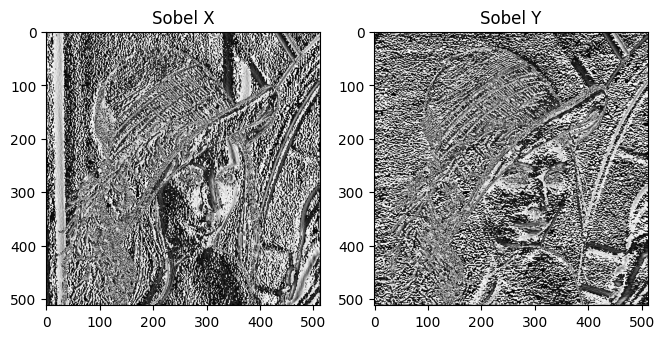

In [28]:
image = cv2.imread('Images/lena.png', cv2.IMREAD_GRAYSCALE)

# Apply Sobel X and Y kernels
sobel_x_output = convolve_2d(image, sobel_x)
sobel_y_output = convolve_2d(image, sobel_y)

sobel_magnitude = np.sqrt(sobel_x_output**2 + sobel_y_output**2)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(sobel_x_output, cmap='gray')
plt.title('Sobel X')

plt.subplot(1, 3, 2)
plt.imshow(sobel_y_output, cmap='gray')
plt.title('Sobel Y')

plt.show()

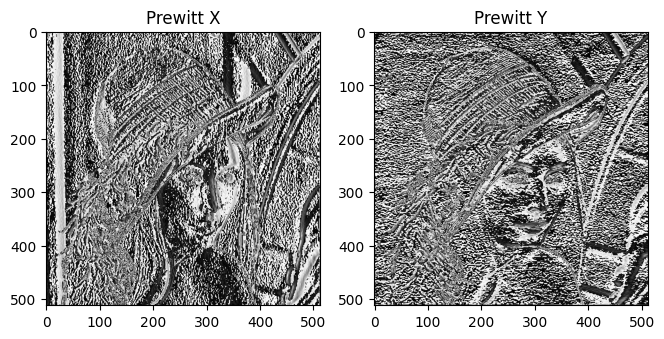

In [29]:
image = cv2.imread('Images/lena.png', cv2.IMREAD_GRAYSCALE)

# Apply Prewitt X and Y kernels
prewitt_x_output = convolve_2d(image, prewitt_x)
prewitt_y_output = convolve_2d(image, prewitt_y)

prewitt_magnitude = np.sqrt(prewitt_x_output**2 + prewitt_y_output**2)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(prewitt_x_output, cmap='gray')
plt.title('Prewitt X')

plt.subplot(1, 3, 2)
plt.imshow(prewitt_y_output, cmap='gray')
plt.title('Prewitt Y')


plt.show()

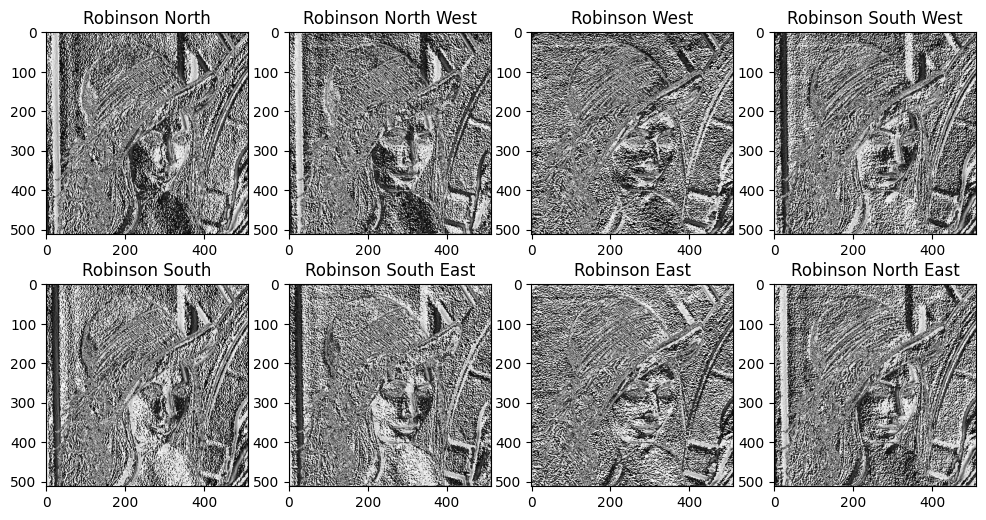

In [30]:
image = cv2.imread('Images/lena.png', cv2.IMREAD_GRAYSCALE)

# Apply Robinson Kernels
robinson_north_output = convolve_2d(image, robinson_north)
robinson_north_west_output = convolve_2d(image, robinson_north_west)
robinson_west_output = convolve_2d(image, robinson_west)
robinson_south_west_output = convolve_2d(image, robinson_south_west)
robinson_south_output = convolve_2d(image, robinson_south)
robinson_south_east_output = convolve_2d(image, robinson_south_east)
robinson_east_output = convolve_2d(image, robinson_east)
robinson_north_east_output = convolve_2d(image, robinson_north_east)

robinson_magnitude = np.sqrt(robinson_north_output**2 + robinson_north_west_output**2 + robinson_west_output**2 + robinson_south_west_output**2 + robinson_south_output**2 + robinson_south_east_output**2 + robinson_east_output**2 + robinson_north_east_output**2)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(2, 4, 1)
plt.imshow(robinson_north_output, cmap='gray')
plt.title('Robinson North')

plt.subplot(2, 4, 2)
plt.imshow(robinson_north_west_output, cmap='gray')
plt.title('Robinson North West')

plt.subplot(2, 4, 3)
plt.imshow(robinson_west_output, cmap='gray')
plt.title('Robinson West')

plt.subplot(2, 4, 4)
plt.imshow(robinson_south_west_output, cmap='gray')
plt.title('Robinson South West')

plt.subplot(2, 4, 5)
plt.imshow(robinson_south_output, cmap='gray')
plt.title('Robinson South')

plt.subplot(2, 4, 6)
plt.imshow(robinson_south_east_output, cmap='gray')
plt.title('Robinson South East')

plt.subplot(2, 4, 7)
plt.imshow(robinson_east_output, cmap='gray')
plt.title('Robinson East')

plt.subplot(2, 4, 8)
plt.imshow(robinson_north_east_output, cmap='gray')
plt.title('Robinson North East')

plt.show()


# 4. Gaussian Kernel for Smoothing an Image

In [12]:
def generate_gaussian_kernel(size, sigma):
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x - size//2)**2 + (y - size//2)**2) / (2*sigma**2)), (size, size))
    kernel /= np.sum(kernel)
    return kernel

In [13]:
def apply_gaussian_smoothing(image, kernel):
    return convolve_2d(image, kernel)

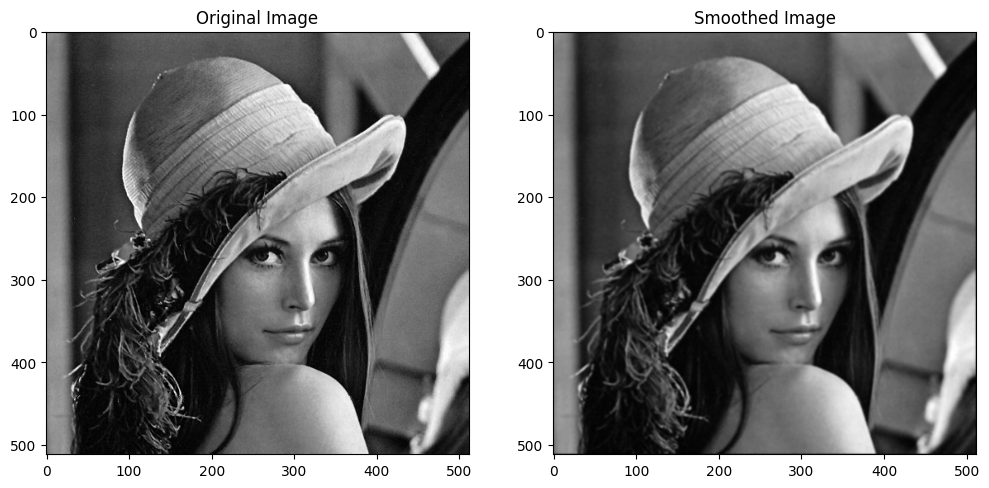

In [14]:
image = cv2.imread('Images/lena.png', cv2.IMREAD_GRAYSCALE)

kernel = generate_gaussian_kernel(5, 1)
smoothed_image = apply_gaussian_smoothing(image, kernel)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(smoothed_image, cmap='gray')
plt.title('Smoothed Image')

plt.show()

# 5. Average and Weighted Average Filter for Smoothing an Image

In [15]:
def average_filter(image, kernel_size):
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)
    return convolve_2d(image, kernel)

In [16]:
def weighted_average_filter(image):
    kernel = np.array([[1, 2, 1],
                       [2, 4, 2],
                       [1, 2, 1]]) / 16
    return convolve_2d(image, kernel)

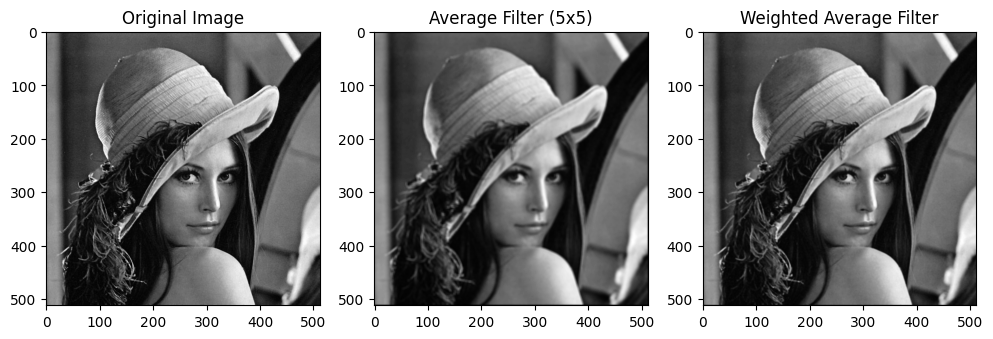

In [17]:
image = cv2.imread('Images/lena.png', cv2.IMREAD_GRAYSCALE)

avg_filtered_image = average_filter(image, 5) 
weighted_filtered_image = weighted_average_filter(image)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(avg_filtered_image, cmap='gray')
plt.title('Average Filter (5x5)')

plt.subplot(1, 3, 3)
plt.imshow(weighted_filtered_image, cmap='gray')
plt.title('Weighted Average Filter')

plt.show()